# FareCast NYC: Identifying Generous Tippers with Predictive Modeling

## Overview

**Executive Summary:**

In this machine learning endeavor, our primary objective is to empower taxi cab drivers by developing a predictive model that identifies and predicts generous tipping behavior among passengers. The ultimate goal is to enhance the revenue generated by taxi drivers, particularly through increased earnings from tips. To achieve this, we aim to construct a model capable of discerning customers who exhibit an exceptionally generous tipping inclination—specifically those who tip 20% or more of the fare amount. By leveraging machine learning techniques, we anticipate uncovering patterns and factors that contribute to a passenger's generosity, providing valuable insights to drivers and taxi service providers. This model not only supports individual drivers in customizing their service but also contributes to the broader optimization of the taxi service industry by fostering a more rewarding experience for both drivers and passengers.

**Ethical Considerations**

In lieu of tip estimation, the focus shifts to identifying generous customers for ethical considerations. Predicting tips poses potential challenges, as drivers may be disheartened if the app incorrectly informs them about a customer's intent to tip. This could erode trust in the application, impacting the overall relationship between drivers and the service. Moreover, if drivers begin avoiding passengers predicted not to tip, it may lead to accessibility issues for customers, especially those who cannot afford additional tips. The model's predictions could inadvertently influence driver behavior, affecting the equitable provision of taxi services. Choosing to identify generous customers mitigates these potential issues, aligning with ethical considerations to ensure fair and unbiased service delivery.

**Data Sources:**

This project relies on the "2017 Yellow Taxi Trip Data" as the primary dataset, sourced from NYC OpenData. The dataset, processed and exported from `fare_estimation.ipynb`, provides comprehensive information about taxi and for-hire vehicle trips.

For a detailed understanding of each attribute and its significance, please refer to the [Data Dictionary](https://github.com/sssunri/farecast_NYC-TLC_estimation/blob/main/data_dictionary_trip_records_yellow.pdf) presented by the New York City Taxi & Limousine Commission. The richness of this data dictionary is instrumental in comprehending the dataset, a crucial aspect in constructing a reliable fare estimation model.

To facilitate accurate prediction, the model requires historical behavioral data for each customer, including tipping patterns from previous taxi rides. Essential features encompass timestamps, dates, locations of pickups and dropoffs, estimated fares, and payment methods. The binary target variable signifies whether the customer is anticipated to tip ≥ 20%.

## Data Exploration

**Load the Data**

In [1]:
# packages for numerics + dataframes
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', None)

# packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 15, 5

# packages for OLS, MLR, confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# function that helps plot feature importance 
from xgboost import plot_importance

# save your models and read them back in
from pathlib import Path
import pickle

In [2]:
# load dataset into dataframe
df = pd.read_csv('data/2017_Yellow_Taxi_Trip_Data_Export.csv')

**Initial Exploration**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22644 entries, 0 to 22643
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               22644 non-null  int64  
 1   tpep_pickup_datetime   22644 non-null  object 
 2   tpep_dropoff_datetime  22644 non-null  object 
 3   passenger_count        22644 non-null  int64  
 4   trip_distance          22644 non-null  float64
 5   RatecodeID             22644 non-null  int64  
 6   store_and_fwd_flag     22644 non-null  object 
 7   PULocationID           22644 non-null  int64  
 8   DOLocationID           22644 non-null  int64  
 9   payment_type           22644 non-null  int64  
 10  fare_amount            22644 non-null  float64
 11  extra                  22644 non-null  float64
 12  tip_amount             22644 non-null  float64
 13  tolls_amount           22644 non-null  float64
 14  total_amount           22644 non-null  float64
 15  mo

## Feature Engineering

**Analysis of Average Tips Based on Payment Type**

In [4]:
# what is the average tip for trips paid for with credit card?
credit_avg_tip = df[df['payment_type'] == 1].mean(numeric_only=True)['tip_amount']
print(f'credit card average tip: ${credit_avg_tip:.2f}')

# what is the average tip for trips paid for with cash?
cash_avg_tip = df[df['payment_type'] == 2].mean(numeric_only=True)['tip_amount']
print(f'cash average tip: ${cash_avg_tip}')

credit card average tip: $2.70
cash average tip: $0.0


Examining the tipping patterns based on payment methods reveals interesting insights. On average, trips paid with credit cards receive a substantial tip of \\$2.70. In contrast, cash payments show an apparent difference, with an average tip of \\$0.00. This stark contrast in tipping behavior between credit card and cash transactions highlights a potential distinction in customer preferences and tipping practices.

To streamline the modeling objective of predicting generous tippers, we will narrow down our focus by sampling data exclusively from customers who opt for credit card payments. This targeted approach aims to capture patterns specific to credit card transactions, providing a more refined dataset for accurate prediction and analysis.

In [5]:
# subset the data to isolate only customers who paid by credit card
df = df[df['payment_type'] == 1].copy()
df['payment_type'].unique()

array([1], dtype=int64)

**Creating Binary Indicator for Generous Tips**

To better facilitate the modeling objective, we will introduce a new binary column, `generous_tip`, serving as the target variable. This column will act as a clear indicator, assigning a value of 1 if the customer tipped 20% or more and 0 otherwise. By incorporating this binary classification, the model can precisely identify and predict customers who exhibit generous tipping behavior, streamlining the focus on those likely to leave substantial tips.

In [6]:
df['generous_tip'] = df['tip_percent'].copy()
df['generous_tip'] = (df['tip_percent'] >= 0.2).astype(int)
df['generous_tip'].head()

0    1
1    1
2    0
3    1
5    1
Name: generous_tip, dtype: int32

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,month,day,hour,time_of_day,season,duration,pickup_dropoff,mean_distance,mean_duration,tip_percent,trip_speed_mph,date,rush_hour,predicted_fare,generous_tip
0,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,2.76,0.0,16.56,March,Saturday,8,am_rush,2,14.07,100 231,3.521667,22.848333,0.200,14.243070,2017-03-25,0,13.636419,1
1,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,4.00,0.0,20.80,April,Tuesday,14,daytime,2,26.50,186 43,3.108889,24.470000,0.238,4.075472,2017-04-11,0,13.916246,1
2,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,1.45,0.0,8.75,December,Friday,7,am_rush,1,7.20,262 236,0.881429,7.250286,0.199,8.333333,2017-12-15,1,7.128055,0
3,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,6.39,0.0,27.69,May,Sunday,13,daytime,2,30.25,188 97,3.700000,30.250000,0.300,7.338843,2017-05-07,0,18.647323,1
5,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,2.06,0.0,12.36,March,Saturday,20,nighttime,2,8.00,161 236,2.052258,11.855484,0.200,17.250000,2017-03-25,0,9.921377,1


## Prepare a Model

### Isolate Modeling Variables

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15249 entries, 0 to 22643
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               15249 non-null  int64  
 1   tpep_pickup_datetime   15249 non-null  object 
 2   tpep_dropoff_datetime  15249 non-null  object 
 3   passenger_count        15249 non-null  int64  
 4   trip_distance          15249 non-null  float64
 5   RatecodeID             15249 non-null  int64  
 6   store_and_fwd_flag     15249 non-null  object 
 7   PULocationID           15249 non-null  int64  
 8   DOLocationID           15249 non-null  int64  
 9   payment_type           15249 non-null  int64  
 10  fare_amount            15249 non-null  float64
 11  extra                  15249 non-null  float64
 12  tip_amount             15249 non-null  float64
 13  tolls_amount           15249 non-null  float64
 14  total_amount           15249 non-null  float64
 15  mo

In [9]:
df2 = df.copy()
df2 = df2.drop([
    'tpep_pickup_datetime', 'tpep_dropoff_datetime','store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', 'tip_amount', \
    'tolls_amount', 'total_amount', 'hour', 'season', 'pickup_dropoff', 'mean_distance', 'mean_duration', 'tip_percent', \
    'trip_speed_mph', 'date', 'rush_hour'], 
    axis=1)

In [10]:
df2.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,month,day,time_of_day,duration,predicted_fare,generous_tip
0,2,6,3.34,1,100,231,March,Saturday,am_rush,14.07,13.636419,1
1,1,1,1.80,1,186,43,April,Tuesday,daytime,26.50,13.916246,1
2,1,1,1.00,1,262,236,December,Friday,am_rush,7.20,7.128055,0
3,2,1,3.70,1,188,97,May,Sunday,daytime,30.25,18.647323,1
5,2,6,2.30,1,161,236,March,Saturday,nighttime,8.00,9.921377,1


### Variable Encoding

A significant portion of the dataset includes categorical columns that require encoding into binary format. While some columns are numerically represented, they actually convey categorical information, examples being RatecodeID and the pickup/dropoff locations. To facilitate proper recognition as categorical variables for the `get_dummies()` function, it's crucial to convert these columns to type `str`. This conversion ensures accurate encoding of categorical attributes, allowing for effective feature transformation and enhancement of the model's predictive capabilities.

In [11]:
# convert columns to str type
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'time_of_day']
for i in cols_to_str:
    df2[i] = df2[i].astype('str')

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15249 entries, 0 to 22643
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15249 non-null  int64  
 1   passenger_count  15249 non-null  int64  
 2   trip_distance    15249 non-null  float64
 3   RatecodeID       15249 non-null  object 
 4   PULocationID     15249 non-null  object 
 5   DOLocationID     15249 non-null  object 
 6   month            15249 non-null  object 
 7   day              15249 non-null  object 
 8   time_of_day      15249 non-null  object 
 9   duration         15249 non-null  float64
 10  predicted_fare   15249 non-null  float64
 11  generous_tip     15249 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(6)
memory usage: 1.5+ MB


In [13]:
df2 = pd.get_dummies(df2, drop_first=True)

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15249 entries, 0 to 22643
Columns: 345 entries, VendorID to time_of_day_pm_rush
dtypes: float64(3), int32(1), int64(2), uint8(339)
memory usage: 5.7 MB


### Class Balance Analysis

In [15]:
# examine the class balance of target variable
df2['generous_tip'].value_counts(normalize=True)

1    0.525346
0    0.474654
Name: generous_tip, dtype: float64

Upon examining the class balance of the target variable, it's evident that approximately 52.5% of customers in the dataset were classified as "generous" (tipped ≥ 20%), while the remaining 47.5% did not meet this criterion. The dataset exhibits a near balance, with a slight majority falling into the "generous" category. 

Choosing a suitable metric for model evaluation involves considering the impact of false positives and false negatives on both taxi drivers and customers. False positives, where the model predicts a tip ≥ 20%, but the customer doesn't tip generously, can frustrate drivers. On the other hand, false negatives, where the model predicts a tip < 20%, but the customer tips generously, can potentially lead to a driver missing out on a more lucrative opportunity.

Given the balanced stakes, a metric that equally weighs precision and recall is essential. The F1 score serves this purpose, providing a comprehensive evaluation that considers both true positives and false negatives. This balanced metric ensures a fair assessment of the model's performance, aligning with the dual objective of enhancing taxi driver earnings without compromising customer satisfaction.

In [16]:
scoring = {'precision', 'recall', 'f1', 'accuracy'}

### Split Data into Outcome Variable and Features

In [17]:
X = df2.drop(columns='generous_tip', axis=1).copy()

In [18]:
y = df2['generous_tip']

### Split Data into Training and Testing Sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12199, 344), (3050, 344), (12199,), (3050,))

## Random Forest

In [21]:
rf = RandomForestClassifier(random_state=42)

In [22]:
# create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [None],
    'max_features': [1.0],
    'max_samples': [0.7],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [300]
}

In [23]:
rf = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=4, refit='f1')

### Fit the Model

In [24]:
%%time
rf.fit(X=X_train, y=y_train)

Wall time: 10min 8s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'recall', 'f1', 'precision', 'accuracy'})

### Evaluate RF Model

**Train Data**

In [25]:
print(f'best average score across all validation folds: {rf.best_score_}')

best average score across all validation folds: 0.7357804823702909


In [26]:
print('best combination of hyperparameters:')
rf.best_params_

best combination of hyperparameters:


{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

**Test Data**

In [27]:
rf_pred = rf.best_estimator_.predict(X=X_test)

**Performance Analysis**

In [28]:
# output all scores of model
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # create table of results
    table = pd.DataFrame({
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'F1': [f1],
        'accuracy': [accuracy]
    })

    return table

In [29]:
results = make_results('RF CV', rf, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.684957,0.794811,0.73578,0.700549


In [30]:
# output the scores of the model on the test data
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'F1': [f1],
        'accuracy': [accuracy]
    })

    return table

In [31]:
# generate the scores on the test data
rf_test_scores = get_test_scores('RF Test', rf_pred, y_test)
results = pd.concat([results, rf_test_scores])
results

,model,precision,recall,F1,accuracy
0,RF CV,0.684957,0.794811,0.735780,0.700549
0,RF Test,0.688735,0.800248,0.740316,0.703279


The Random Forest model demonstrates commendable performance, achieving an F1 score of approximately 73.6% on the training data and 74.0% on the test data. This suggests that the model strikes a balance between precision and recall, effectively identifying generous customers without compromising the prediction of non-generous ones.

Precision, recall, and accuracy metrics provide a comprehensive understanding of the model's strengths. A precision of 68.9% indicates the proportion of predicted generous customers that were actually generous, while a recall of 80.0% indicates the proportion of actual generous customers correctly identified by the model. The accuracy of 70.3% reflects the overall correctness of the model's predictions.

This balanced performance, as indicated by the F1 score, demonstrates the Random Forest model's effectiveness in identifying customers likely to provide generous tips, providing valuable insights for taxi drivers to optimize their earnings without compromising service quality.

## XGBoost

In [32]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

In [33]:
# create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [8],
    'min_child_weight': [2],
    'learning_rate': [0.1],
    'n_estimators': [500]
}

In [34]:
xgb = GridSearchCV(estimator=xgb, param_grid=cv_params, scoring=scoring, cv=4, refit='f1')

### Fit the Model

In [35]:
%%time
xgb.fit(X=X_train, y=y_train)

Wall time: 23.6 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring={'recall', 'f1', 'precision', 'accuracy'})

### Evaluate Model

**Train Data**

In [36]:
print(f'best average score across all validation folds: {xgb.best_score_}')

best average score across all validation folds: 0.6992065840955117


In [37]:
print('best combination of hyperparameters:')
xgb.best_params_

best combination of hyperparameters:


{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

**Test Data**

In [38]:
xgb_pred = xgb.best_estimator_.predict(X_test)

**Performance Analysis**

In [39]:
xgb_cv_results = make_results('XGB CV', xgb, 'f1')
results = pd.concat([results, xgb_cv_results])

In [40]:
xgb_test_scores = get_test_scores('XGB Test', xgb_pred, y_test)
results = pd.concat([results, xgb_test_scores])
results

,model,precision,recall,F1,accuracy
0,RF CV,0.684957,0.794811,0.735780,0.700549
0,RF Test,0.688735,0.800248,0.740316,0.703279
0,XGB CV,0.673160,0.727455,0.699207,0.671694
0,XGB Test,0.681381,0.746898,0.712637,0.681639


The RF model exhibits competitive precision, recall, F1 score, and accuracy. While the F1 score is marginally higher for the RF model, the XGBoost model might present a different trade-off depending on the specific use case. However, the Random Forest model, with its solid performance across multiple metrics, emerges as a robust choice for predicting generous customers.

This preference for Random Forest is driven by its balanced and reliable performance, making it well-suited for deployment in a real-world scenario. Its ability to handle non-linearity, interactions, and complex relationships within the data makes it a preferable choice for this particular classification task. Ultimately, stakeholders can be confident in the Random Forest model's capability to predict generous tippers, enhancing the efficiency and revenue potential for taxi drivers.

**Confusion Matrix Analysis: Random Forest Model**

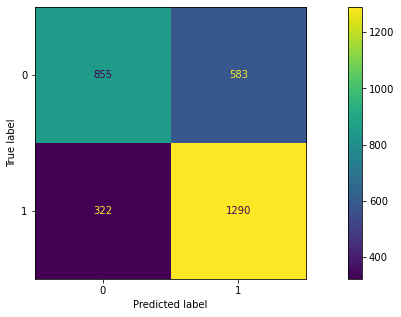

In [41]:
# plot confusion matrix of the model's predictions on the test data
cm = confusion_matrix(y_true=y_test, y_pred=rf_pred, labels=rf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
log_disp.plot(values_format='')
plt.show()

The confusion matrix reveals valuable insights into the model's classification performance. In this context, the Random Forest model is more prone to false positives than false negatives, with 855 instances of false positives and 322 instances of false negatives. This imbalance indicates that the model tends to predict a generous tip (positive class) more frequently, potentially resulting in drivers being pleasantly surprised by higher tips when not anticipated.

While the preference is generally for fewer false positives, the impact on driver satisfaction and earnings is a critical consideration. The model's propensity for type I errors aligns with the objective of maximizing drivers' opportunities for higher tips, even if it occasionally leads to overestimation. However, it's crucial to monitor and manage false positives to maintain customer satisfaction.

**Feature Importance**

In [42]:
importances = rf.best_estimator_.feature_importances_
rf_importances = pd.Series(data=importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

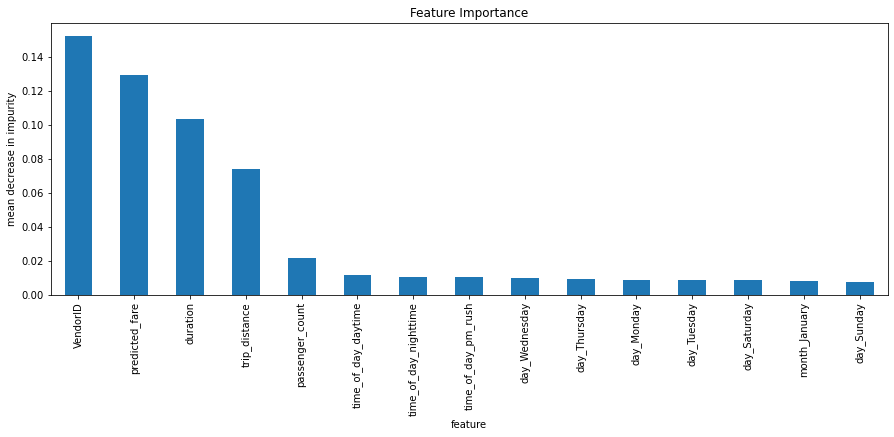

In [43]:
rf_importances.plot.bar()
plt.title('Feature Importance')
plt.xlabel('feature')
plt.ylabel('mean decrease in impurity')
plt.show()

## Conclusion

In conclusion, this notebook aimed to develop a predictive model to identify customers likely to leave generous tips, defined as tips of 20% or more. Leveraging the Random Forest algorithm and a dataset enriched with engineered features, the model demonstrated competitive performance with an F1 score of approximately 74%. The analysis revealed a preference for predicting positive instances, potentially leading to more false positives than false negatives.

The inherent trade-off between false positives and false negatives is a critical consideration, especially in the context of customer and driver satisfaction. The model's inclination toward type I errors aligns with the goal of maximizing driver earnings by occasionally overestimating tips. However, stakeholders should carefully manage and monitor these predictions to maintain a balance between driver satisfaction and customer expectations.

As with any predictive model, ongoing evaluation and adjustment are essential to align with evolving business priorities and objectives. The insights derived from this notebook provide a foundation for optimizing the model and refining strategies to enhance the overall efficiency of taxi services and promote positive interactions between drivers and customers.

**Acknowledgments**

This project is inspired by the [Google Advanced Data Analytics Professional Certificate](https://www.coursera.org/professional-certificates/google-advanced-data-analytics) program, specifically the end-of-course portfolio project titled *Automatidata*.

This project utilises a subset of the [2017 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2017-Yellow-Taxi-Trip-Data/biws-g3hs) obtained from the New York City Taxi & Limousine Commission, originally published as part of the NYC Open Data program. The dataset, containing 22,699 rows representing different trips and 18 columns, was provided by the Google Advanced Data Analytics Professional Certificate program for the purpose of the end-of-course portfolio project. Invaluable insights into the dataset's attributes and their meanings were derived from the detailed [Data Dictionary](https://data.cityofnewyork.us/api/views/biws-g3hs/files/eb3ccc47-317f-4b2a-8f49-5a684b0b1ecc?download=true&filename=data_dictionary_trip_records_yellow.pdf) provided by the New York City Taxi & Limousine Commission. We acknowledge the contribution of both the NYC TLC and the Google program to the dataset used in this analysis.